In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

# Standard library
import os
import re
import sys
import contextlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all="ignore")
import pandas as pd

# To Save and load the Model
import joblib

# Scikit-learn: model selection & metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

# Scikit-learn: preprocessing & feature selection
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel

# Scikit-learn: models
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Gradient boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Hyperparameter optimization
import optuna

In [2]:
TARGET_COL = "Default"   

numeric_cols = [
    "Client_Income", "Child_Count", "Credit_Amount", "Loan_Annuity",
    "Population_Region_Relative", "Age_Days", "Employed_Days",
    "Registration_Days", "ID_Days", "Own_House_Age",
    "Client_Family_Members", "Score_Source_1", "Score_Source_2",
    "Score_Source_3", "Social_Circle_Default", "Phone_Change",
    "Credit_Bureau"
]

categorical_cols = [
    "Car_Owned", "Bike_Owned", "Active_Loan", "House_Own",
    "Accompany_Client", "Client_Income_Type", "Client_Education",
    "Client_Marital_Status", "Client_Gender",
    "Loan_Contract_Type", "Client_Housing_Type",
    "Mobile_Tag", "Homephone_Tag", "Workphone_Working",
    "Client_Occupation", "Application_Process_Day",
    "Application_Process_Hour", "Client_Permanent_Match_Tag",
    "Client_Contact_Work_Tag", "Type_Organization",
    "Cleint_City_Rating"
]


# Functions

In [3]:
def tune_models(X_train_tune_raw, y_train_tune, X_valid_raw, y_valid):
    print("\n================= STEP 0: Hyperparameter Tuning =================")

    # ==============================================================
    # PREPROCESS TRAIN & VALID (NO SMOTE DURING TUNING)
    # ==============================================================
    print("Preprocessing tuning data...")
    X_train_tune = preprocess_for_tuning(X_train_tune_raw, mode="train")
    X_valid      = preprocess_for_tuning(X_valid_raw, mode="infer")

    # Stratified K-Fold for robust hyperparameter tuning
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Imbalance ratio for tree-based models
    pos_weight = float(np.sum(y_train_tune == 0)) / np.sum(y_train_tune == 1)

    # ==============================================================
    # 1) LOGISTIC REGRESSION (ElasticNet)
    # ==============================================================
    print("\n1/4: Tuning Logistic Regression...")

    def obj_lr(trial):
        params = {
            "C": trial.suggest_float("C", 0.001, 1.0, log=True),
            "penalty": "elasticnet",
            "solver": "saga",
            "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
            "max_iter": 2000,
            "n_jobs": -1,
            "class_weight": "balanced"
        }
        model = LogisticRegression(**params)

        pr_scores = []
        for tr_idx, val_idx in skf.split(X_train_tune, y_train_tune):
            X_tr_cv = X_train_tune.iloc[tr_idx]
            X_val_cv = X_train_tune.iloc[val_idx]
            y_tr_cv = y_train_tune.iloc[tr_idx]
            y_val_cv = y_train_tune.iloc[val_idx]

            model.fit(X_tr_cv, y_tr_cv)
            preds = model.predict_proba(X_val_cv)[:, 1]
            pr_scores.append(average_precision_score(y_val_cv, preds))

        return float(np.mean(pr_scores))

    study_lr = optuna.create_study(direction='maximize')
    study_lr.optimize(obj_lr, n_trials=12)
    best_lr_params = study_lr.best_params


    # ==============================================================
    # 2) CATBOOST
    # ==============================================================
    print("\n2/4: Tuning CatBoost...")

    def obj_cat(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 800),
            'depth': trial.suggest_int('depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 20),
            'random_strength': trial.suggest_float('random_strength', 1, 20),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'verbose': 0,
            'loss_function': 'Logloss',
            'eval_metric': 'PRAUC'
        }
        model = CatBoostClassifier(**params)

        pr_scores = []
        for tr_idx, val_idx in skf.split(X_train_tune, y_train_tune):
            X_tr_cv = X_train_tune.iloc[tr_idx]
            X_val_cv = X_train_tune.iloc[val_idx]
            y_tr_cv = y_train_tune.iloc[tr_idx]
            y_val_cv = y_train_tune.iloc[val_idx]

            model.fit(X_tr_cv, y_tr_cv)
            preds = model.predict_proba(X_val_cv)[:, 1]
            pr_scores.append(average_precision_score(y_val_cv, preds))

        return float(np.mean(pr_scores))

    study_cat = optuna.create_study(direction='maximize')
    study_cat.optimize(obj_cat, n_trials=12)
    best_cat_params = study_cat.best_params


    # ==============================================================
    # 3) XGBOOST
    # ==============================================================
    print("\n3/4: Tuning XGBoost...")

    def obj_xgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 900),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1, 20),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),
            'tree_method': 'hist',
            'objective': 'binary:logistic',
            'n_jobs': -1,
            'random_state': 42,
            'scale_pos_weight': pos_weight
        }
        model = XGBClassifier(**params)

        pr_scores = []
        for tr_idx, val_idx in skf.split(X_train_tune, y_train_tune):
            X_tr_cv = X_train_tune.iloc[tr_idx]
            X_val_cv = X_train_tune.iloc[val_idx]
            y_tr_cv = y_train_tune.iloc[tr_idx]
            y_val_cv = y_train_tune.iloc[val_idx]

            model.fit(X_tr_cv, y_tr_cv)
            preds = model.predict_proba(X_val_cv)[:, 1]
            pr_scores.append(average_precision_score(y_val_cv, preds))

        return float(np.mean(pr_scores))

    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(obj_xgb, n_trials=12)
    best_xgb_params = study_xgb.best_params


    # ==============================================================
    # 4) LIGHTGBM
    # ==============================================================
    print("\n4/4: Tuning LightGBM...")

    def obj_lgbm(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 900),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_child_samples': trial.suggest_int('min_child_samples', 50, 120),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'reg_alpha': trial.suggest_float('reg_alpha', 1, 20),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),
            'n_jobs': -1,
            'random_state': 42,
            'verbose': -1,
            'scale_pos_weight': pos_weight
        }
        model = LGBMClassifier(**params)

        pr_scores = []
        for tr_idx, val_idx in skf.split(X_train_tune, y_train_tune):
            X_tr_cv = X_train_tune.iloc[tr_idx]
            X_val_cv = X_train_tune.iloc[val_idx]
            y_tr_cv = y_train_tune.iloc[tr_idx]
            y_val_cv = y_train_tune.iloc[val_idx]

            model.fit(X_tr_cv, y_tr_cv)
            preds = model.predict_proba(X_val_cv)[:, 1]
            pr_scores.append(average_precision_score(y_val_cv, preds))

        return float(np.mean(pr_scores))

    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(obj_lgbm, n_trials=12)
    best_lgbm_params = study_lgbm.best_params


    # ==============================================================
    # ENSEMBLE WEIGHT SCANNING (EXPANDED WEIGHTS)
    # ==============================================================
    print("\nScanning best ensemble weights (expanded grid)...")

    # Train final models with tuned params
    lr_final   = LogisticRegression(**best_lr_params, max_iter=2000).fit(X_train_tune, y_train_tune)
    cat_final  = CatBoostClassifier(**best_cat_params, verbose=0).fit(X_train_tune, y_train_tune)
    xgb_final  = XGBClassifier(**best_xgb_params).fit(X_train_tune, y_train_tune)
    lgbm_final = LGBMClassifier(**best_lgbm_params).fit(X_train_tune, y_train_tune)

    # Predictions
    p_lr   = lr_final.predict_proba(X_valid)[:,1]
    p_cat  = cat_final.predict_proba(X_valid)[:,1]
    p_xgb  = xgb_final.predict_proba(X_valid)[:,1]
    p_lgbm = lgbm_final.predict_proba(X_valid)[:,1]

    # Expanded weight options
    weight_options = list(range(0, 11))  # 0–10 weights

    best_auc = 0
    best_weights = (1,1,1,1)

    for w in product(weight_options, repeat=4):
        if sum(w) == 0:
            continue

        avg_pred = (
            p_lr*w[0] +
            p_cat*w[1] +
            p_xgb*w[2] +
            p_lgbm*w[3]
        ) / sum(w)

        pr_auc = average_precision_score(y_valid, avg_pred)

        if pr_auc > best_auc:
            best_auc = pr_auc
            best_weights = w

    print(f"\n>>> BEST WEIGHTS = {best_weights}, PR-AUC={best_auc:.4f}")

    return (
        best_lr_params,
        best_cat_params,
        best_xgb_params,
        best_lgbm_params,
        best_weights
    )

In [4]:
# 2. FEATURE ENGINEERING

def add_advanced_features(df):
    df_new = df.copy()

    # --- 1. EXTERNAL SCORE AGGREGATIONS ---
    score_cols = ['Score_Source_1', 'Score_Source_2', 'Score_Source_3']
    existing_scores = [c for c in score_cols if c in df_new.columns]

    if existing_scores:
        df_new['NEW_Score_Mean'] = df_new[existing_scores].mean(axis=1)
        df_new['NEW_Score_Max']  = df_new[existing_scores].max(axis=1)
        df_new['NEW_Score_Min']  = df_new[existing_scores].min(axis=1)
        df_new['NEW_Score_Var']  = df_new[existing_scores].var(axis=1)

    # --- 2. FINANCIAL CAPACITY ---
    if 'Loan_Annuity' in df_new.columns and 'Credit_Amount' in df_new.columns:
        df_new['NEW_Payment_Rate'] = df_new['Loan_Annuity'] / (df_new['Credit_Amount'] + 1)

    # --- 3. STABILITY METRICS ---
    if 'Employed_Days' in df_new.columns and 'Age_Days' in df_new.columns:
        df_new['NEW_Employed_Ratio'] = df_new['Employed_Days'] / (df_new['Age_Days'] + 1)

    if 'ID_Days' in df_new.columns and 'Age_Days' in df_new.columns:
        df_new['NEW_ID_Change_Ratio'] = df_new['ID_Days'] / (df_new['Age_Days'] + 1)

    # --- 4. INTERACTION FEATURES ---
    if 'Client_Income' in df_new.columns and 'Age_Days' in df_new.columns:
        df_new['NEW_Income_per_Age'] = df_new['Client_Income'] / (df_new['Age_Days'] + 1)

    if 'Client_Income' in df_new.columns and 'Population_Region_Relative' in df_new.columns:
        df_new['NEW_Region_Adjusted_Income'] = (
            df_new['Client_Income'] * df_new['Population_Region_Relative']
        )

    return df_new

# ============================================================
# 3. BASIC UTILITIES: IMPUTE, ENCODE, SCALE, BALANCE
# ============================================================

def smart_impute(df, numerical_cols, categorical_cols):
    """
    Fills Nulls: median for numerical, mode for categorical.
    Returns df_clean and dictionary of used impute values.
    """
    df_clean = df.copy()
    impute_values = {}

    # numerical
    for col in numerical_cols:
        if col in df_clean.columns:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            impute_values[col] = median_val

    # categorical
    for col in categorical_cols:
        if col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                mode_val = df_clean[col].mode()[0]
                df_clean[col] = df_clean[col].fillna(mode_val)
                impute_values[col] = mode_val

    return df_clean, impute_values


def encode_categorical(df, categorical_cols):
    """
    Performs One-Hot Encoding on given categorical columns.
    """
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
    return df_encoded


def remove_multicollinearity(df, threshold=0.95):
    """
    Drops features that are highly correlated with each other (> threshold).
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, to_drop


def scale_and_transform(df, numeric_cols):
    #Applies Yeo-Johnson transformation to numeric columns.
    df = df.copy()
    valid_cols = [c for c in numeric_cols if c in df.columns]

    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    df[valid_cols] = pt.fit_transform(df[valid_cols])

    return df, pt


def apply_scaler(df, numeric_cols, pt):
    df = df.copy()
    valid_cols = [c for c in numeric_cols if c in df.columns]
    df[valid_cols] = pt.transform(df[valid_cols])
    return df


def feature_selection_train(X, y, n_estimators=200, random_state=42):
    """Supervised feature selection using ExtraTrees + SelectFromModel.

    Stores selected feature names in PREPROCESSOR["selected_features"]
    so that inference can apply the same reduction.
    """
    global PREPROCESSOR
    X = X.copy()
    selector = ExtraTreesClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    selector.fit(X, y)

    sfm = SelectFromModel(selector, prefit=True, threshold=0.0)
    mask = sfm.get_support()
    selected_cols = X.columns[mask]

    print(f"Features reduced from {X.shape[1]} to {len(selected_cols)} using ExtraTrees feature importances.")
    PREPROCESSOR["selected_features"] = list(selected_cols)

    return X[selected_cols]


def apply_feature_selection(X):
    """Apply previously learned feature selection to any dataframe.

    If no selection was fitted, returns X unchanged.
    """
    global PREPROCESSOR
    if PREPROCESSOR.get("selected_features") is None:
        return X

    cols = PREPROCESSOR["selected_features"]
    # Align columns; missing columns are filled with 0
    X_aligned = X.reindex(columns=cols, fill_value=0)
    return X_aligned



def clean_feature_names(df):
    """
    Cleans column names for LightGBM / JSON safety.
    """
    df = df.copy()
    new_columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in df.columns]
    df.columns = new_columns
    return df

# ============================================================
# 4. PREPROCESSOR STATE (TO SAVE AND REUSE)
# ============================================================

PREPROCESSOR = {
    "numerical_medians": {},
    "categorical_modes": {},
    "power_transformer": None,
    "multicollinearity_drop_cols": [],
    "final_columns": None,
    "ohe_columns": None,
    "selected_features": None
}

def full_preprocess_pipeline(df, numerical_cols, categorical_cols, mode="train"):
    """
    FULL PIPELINE FOR TRAIN / INFERENCE

    mode="train":
        - fits imputers, OHE structure, multicollinearity dropping, scaler
        - stores everything in PREPROCESSOR
        - returns processed DataFrame

    mode="infer":
        - uses saved PREPROCESSOR to transform new data
    """
    global PREPROCESSOR
    df = df.copy()

    # 0. Drop ID-like columns
    id_cols = [c for c in df.columns if "id" in c.lower() and c.lower() != TARGET_COL.lower()]
    df.drop(columns=id_cols, inplace=True, errors="ignore")

    # 1. Feature Engineering
    df = add_advanced_features(df)

    # 2. Imputation
    if mode == "train":
        df_clean, impute_vals = smart_impute(df, numerical_cols, categorical_cols)
        PREPROCESSOR["numerical_medians"] = {k: v for k, v in impute_vals.items() if k in numerical_cols}
        PREPROCESSOR["categorical_modes"] = {k: v for k, v in impute_vals.items() if k in categorical_cols}
    else:
        df_clean = df.copy()
        # numerical
        for col, val in PREPROCESSOR["numerical_medians"].items():
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].fillna(val)
        # categorical
        for col, val in PREPROCESSOR["categorical_modes"].items():
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].fillna(val)

    # 3. One-Hot Encoding
    if mode == "train":
        df_ohe = encode_categorical(df_clean, categorical_cols)
        PREPROCESSOR["ohe_columns"] = df_ohe.columns.tolist()
    else:
        df_ohe = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True, dtype=int)
        df_ohe = df_ohe.reindex(columns=PREPROCESSOR["ohe_columns"], fill_value=0)

    # 4. Drop multicollinear features
    if mode == "train":
        df_mc, dropped_cols = remove_multicollinearity(df_ohe)
        PREPROCESSOR["multicollinearity_drop_cols"] = dropped_cols
    else:
        df_mc = df_ohe.drop(columns=PREPROCESSOR["multicollinearity_drop_cols"], errors="ignore")

    # 5. Clean feature names
    df_mc = clean_feature_names(df_mc)

    # 6. Scaling / Yeo-Johnson
    # numeric_cols after all transformations -> intersection
    numeric_cols_after = [c for c in df_mc.columns if c in numeric_cols or c.startswith("NEW_")]

    if mode == "train":
        df_scaled, pt = scale_and_transform(df_mc, numeric_cols_after)
        PREPROCESSOR["power_transformer"] = pt

        # >>> FINAL SAFETY STEP <<<
        df_scaled = df_scaled.replace([np.inf, -np.inf], np.nan)
        df_scaled = df_scaled.fillna(0)

        PREPROCESSOR["final_columns"] = df_scaled.columns.tolist()
        return df_scaled

    else:
        pt = PREPROCESSOR["power_transformer"]
        df_scaled = apply_scaler(df_mc, numeric_cols_after, pt)

        # >>> FINAL SAFETY STEP <<<
        df_scaled = df_scaled.replace([np.inf, -np.inf], np.nan)
        df_scaled = df_scaled.fillna(0)

        df_final = df_scaled.reindex(columns=PREPROCESSOR["final_columns"], fill_value=0)
        return df_final

In [5]:
def split_data(df):
    print("\n===== STEP 1: Train / Test Split =====")
    
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Train size:", X_train_raw.shape)
    print("Test size:", X_test_raw.shape)

    return X_train_raw, X_test_raw, y_train, y_test

def split_train_valid(X_train_raw, y_train):
    print("\n===== STEP 2: Train / Validation Split (for tuning) =====")

    X_train_tune_raw, X_valid_raw, y_train_tune, y_valid = train_test_split(
        X_train_raw,
        y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )

    print("Tune Train size:", X_train_tune_raw.shape)
    print("Validation size:", X_valid_raw.shape)

    return X_train_tune_raw, X_valid_raw, y_train_tune, y_valid


def preprocess_train(X_train_raw, y_train):
    print("\n===== STEP 2: Preprocessing Training Data =====")
    
    X_train_prep = full_preprocess_pipeline(
        X_train_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="train"
    )

    # --- Supervised feature selection (ExtraTrees) ---
    X_fs = feature_selection_train(X_train_prep, y_train)

    return X_fs, y_train

In [6]:
def train_ensemble(X_train_bal, y_train_bal, X_test_raw, y_test):
    """
    Train a regularized ensemble with internal validation + early stopping
    to reduce overfitting.

    Steps:
    - Preprocess raw test set with the global full_preprocess_pipeline
    - Split balanced train into (train, valid) for early stopping
    - Train LR, CatBoost, XGBoost, LightGBM with more conservative settings
      and early stopping on the validation split
    - Evaluate each model on test
    - Train a soft-voting ensemble on the balanced train set
    """
    print("\n===== STEP 3: Training Models + Individual Evaluations (REGULARIZED) =====")

    # 1) Preprocess TEST in infer mode
    X_test_prep = full_preprocess_pipeline(
        X_test_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="infer"
    )
    # Apply the same supervised feature selection used at training time
    X_test_prep = apply_feature_selection(X_test_prep)

    # 2) Internal train/valid split on the already-balanced, preprocessed train
    print("\nCreating internal validation split for early stopping...")
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_bal,
        y_train_bal,
        test_size=0.2,
        stratify=y_train_bal,
        random_state=42
    )
    # Imbalance ratio for tree models
    pos_weight = float(np.sum(y_train_bal == 0)) / np.sum(y_train_bal == 1)
    print("Train (for model fit) shape:", X_tr.shape)
    print("Valid (for early stopping) shape:", X_val.shape)

    # ============================
    #  A) Logistic Regression
    # ============================
    print("\nTraining Logistic Regression (regularized)...")
    lr_params = best_lr_params.copy()
    # Make sure LR is reasonably regularized & robust
    if "C" in lr_params:
        lr_params["C"] = min(lr_params["C"], 1.0)
    lr_params.setdefault("penalty", "l2")
    lr_params.setdefault("class_weight", "balanced")
    lr_params.setdefault("solver", "lbfgs")

    lr_final = LogisticRegression(
        **lr_params,
        max_iter=2000,
        n_jobs=-1
    )
    # LR is stable enough to use full balanced train
    lr_final.fit(X_train_bal, y_train_bal)
    lr_metrics = evaluate_single_model(lr_final, "Logistic Regression", X_test_prep, y_test)

    # ============================
    #  B) CatBoost
    # ============================
    print("\nTraining CatBoost (with early stopping)...")
    cat_params = best_cat_params.copy()
    # Slightly conservative depth / regularization
    if "depth" in cat_params:
        cat_params["depth"] = min(cat_params["depth"], 8)
    if "l2_leaf_reg" in cat_params:
        cat_params["l2_leaf_reg"] = max(cat_params["l2_leaf_reg"], 3.0)

    cat_final = CatBoostClassifier(
        **cat_params,
        auto_class_weights="Balanced",
        verbose=0
    )
    cat_final.fit(
        X_tr,
        y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    cat_metrics = evaluate_single_model(cat_final, "CatBoost", X_test_prep, y_test)

    # ============================
    #  C) XGBoost
    # ============================
    print("\nTraining XGBoost (with early stopping)...")
    xgb_params = best_xgb_params.copy()
    # Cap depth / n_estimators / learning rate for better generalization
    if "max_depth" in xgb_params:
        xgb_params["max_depth"] = min(xgb_params["max_depth"], 6)
    if "n_estimators" in xgb_params:
        xgb_params["n_estimators"] = min(xgb_params["n_estimators"], 800)
    if "learning_rate" in xgb_params:
        xgb_params["learning_rate"] = min(xgb_params["learning_rate"], 0.1)

    xgb_final = XGBClassifier(
        **xgb_params,
        tree_method="hist",
        objective="binary:logistic",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=pos_weight,
        eval_metric="aucpr"

    )
    xgb_final.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    xgb_metrics = evaluate_single_model(xgb_final, "XGBoost", X_test_prep, y_test)

    # ============================
    #  D) LightGBM
    # ============================
    print("\nTraining LightGBM (with early stopping)...")
    lgbm_params = best_lgbm_params.copy()
    # Cap complexity for generalization
    if "max_depth" in lgbm_params:
        lgbm_params["max_depth"] = min(lgbm_params["max_depth"], 6)
    if "num_leaves" in lgbm_params:
        lgbm_params["num_leaves"] = min(lgbm_params["num_leaves"], 63)
    if "learning_rate" in lgbm_params:
        lgbm_params["learning_rate"] = min(lgbm_params["learning_rate"], 0.1)

    lgbm_final = LGBMClassifier(
        **lgbm_params,
        class_weight="balanced",
        random_state=42,
        verbose=-1
    )
    lgbm_final.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc"
    )
    lgbm_metrics = evaluate_single_model(lgbm_final, "LightGBM", X_test_prep, y_test)

    # ============================
    #  E) Compare Individual Models
    # ============================
    import pandas as _pd

    comparison_df = _pd.DataFrame([
        lr_metrics,
        cat_metrics,
        xgb_metrics,
        lgbm_metrics
    ])
    print("\n=== Individual Model Comparison (Test Set) ===")
    display(comparison_df)

    # ============================
    #  F) Soft Voting Ensemble
    # ============================
    print("\nTraining Soft Voting Ensemble (regularized models)...")

    final_ensemble = VotingClassifier(
        estimators=[
            ("lr", lr_final),
            ("cat", cat_final),
            ("xgb", xgb_final),
            ("lgbm", lgbm_final)
        ],
        voting="soft",
        weights=best_weights,
        n_jobs=-1
    )
    final_ensemble.fit(X_train_bal, y_train_bal)

    print("\nEnsemble training complete.")
    return final_ensemble


In [7]:
def evaluate_single_model(model, name, X_test_prep, y_test):
    print(f"\n=========== Evaluating {name} ===========")

    y_probs = model.predict_proba(X_test_prep)[:, 1]
    y_pred = (y_probs >= BEST_THRESHOLD).astype(int)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Accuracy / AUC
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    print("Accuracy:", acc)
    print("AUC:", auc)
    
    return {
        "model": name,
        "accuracy": acc,
        "auc": auc
    }


In [8]:
def evaluate_on_test(model, X_test_raw, y_test):
    print("\n===== STEP 4: Evaluate on Test Set =====")

    X_test_prep = full_preprocess_pipeline(
        X_test_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="infer"
    )

    # Apply the same supervised feature selection used at training time
    X_test_prep = apply_feature_selection(X_test_prep)

    y_probs = model.predict_proba(X_test_prep)[:, 1]

    # Ensure alignment
    y_true = pd.Series(y_test).reset_index(drop=True)
    y_probs = pd.Series(y_probs).reset_index(drop=True)
    y_pred = (y_probs >= BEST_THRESHOLD).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("ROC-AUC:", roc_auc_score(y_true, y_probs))
    print("PR-AUC (average precision):", average_precision_score(y_true, y_probs))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    return y_probs.values, y_pred.values


In [9]:
def preprocess_for_tuning(X_raw, mode):
    return full_preprocess_pipeline(
        X_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode=mode
    )


# Model Starts here

In [10]:
#import kagglehub
import os
import pandas as pd

# Download dataset
#path = kagglehub.dataset_download("gaganagr/dataset2")
# Build full path to your CSV (file inside the dataset folder)
#csv_path = os.path.join(path, "Dataset2.csv")

csv_path='Dataset2.csv'

# Load with pandas
original_df = pd.read_csv(csv_path)

# Drop first unnamed column if needed
if original_df.columns[0].lower().startswith("unnamed"):
    original_df = original_df.drop(original_df.columns[0], axis=1)

print("Original df shape:",original_df.shape)

df = original_df.copy()
df = df.drop(columns=["ID"], errors="ignore")

print("df shape:",df.shape)

Original df shape: (121856, 40)
df shape: (121856, 39)


# Train Validation, test Split

In [11]:
# 1) Split Train/Test
X_train_raw, X_test_raw, y_train, y_test = split_data(df)

# 2) Split Train into Train-Tune and Validation
X_train_tune_raw, X_valid_raw, y_train_tune, y_valid = split_train_valid(X_train_raw, y_train)

# 3) Preprocess Tune Train & Validation (NO SMOTE)
X_train_tune = preprocess_for_tuning(X_train_tune_raw, mode="train")
X_valid      = preprocess_for_tuning(X_valid_raw, mode="infer")


===== STEP 1: Train / Test Split =====
Train size: (97484, 38)
Test size: (24372, 38)

===== STEP 2: Train / Validation Split (for tuning) =====
Tune Train size: (77987, 38)
Validation size: (19497, 38)


In [12]:
# 5) Preprocess full train + SMOTE
print("\n===== STEP 5: Preprocess Full Train + SMOTE =====")
X_train_final, y_train_final = preprocess_train(X_train_raw, y_train)


===== STEP 5: Preprocess Full Train + SMOTE =====

===== STEP 2: Preprocessing Training Data =====
Features reduced from 162 to 162 using ExtraTrees feature importances.


# HyperParameter Tuning

In [13]:
# Already ran and saved results below

# best_lr_params, best_cat_params, best_xgb_params, best_lgbm_params, best_weights = tune_models(X_train_tune_raw,y_train_tune,X_valid_raw,y_valid)

In [14]:
best_lr_params, best_cat_params, best_xgb_params, best_lgbm_params, best_weights=({'C': 0.0021831740860139494, 'l1_ratio': 0.009972972301749539},
 {'iterations': 720,
  'depth': 8,
  'learning_rate': 0.14749085852037502,
  'l2_leaf_reg': 8.325394043482074,
  'random_strength': 10.078404243138106,
  'bagging_temperature': 0.40769575192903906},
 {'n_estimators': 529,
  'learning_rate': 0.11035195585768404,
  'max_depth': 6,
  'min_child_weight': 11,
  'subsample': 0.6954631887061631,
  'colsample_bytree': 0.5874632325940672,
  'gamma': 0.18030890330611782,
  'reg_alpha': 1.5766604818203613,
  'reg_lambda': 12.5237655582215},
 {'n_estimators': 729,
  'learning_rate': 0.13891479514084934,
  'num_leaves': 44,
  'max_depth': 6,
  'min_child_samples': 77,
  'subsample': 0.5243253811425539,
  'colsample_bytree': 0.5047936560952209,
  'reg_alpha': 11.336592038772189,
  'reg_lambda': 15.635562072081797},
 (1, 8, 2, 3))

In [15]:
BEST_THRESHOLD = best_threshold=0.45

## Individual Model Training and Training Soft Voting Ensemble

In [16]:
# 6) Train final ensemble
print("\n===== STEP 6: Train Final Ensemble =====")
model = train_ensemble(
    X_train_final,
    y_train_final,
    X_test_raw,   # raw → infer-preprocessed inside function
    y_test
)

# 7) Evaluate on Test
print("\n===== STEP 7: Evaluate on Test Set =====")
y_probs, y_pred = evaluate_on_test(model, X_test_raw, y_test)



===== STEP 6: Train Final Ensemble =====

===== STEP 3: Training Models + Individual Evaluations (REGULARIZED) =====

Creating internal validation split for early stopping...
Train (for model fit) shape: (77987, 162)
Valid (for early stopping) shape: (19497, 162)

Training Logistic Regression (regularized)...

=========== Evaluating Logistic Regression ===========

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72     22403
           1       0.14      0.75      0.23      1969

    accuracy                           0.59     24372
   macro avg       0.55      0.67      0.48     24372
weighted avg       0.90      0.59      0.68     24372

Confusion Matrix:
[[12985  9418]
 [  485  1484]]
Accuracy: 0.5936730674544559
AUC: 0.729732765647748

Training CatBoost (with early stopping)...

=========== Evaluating CatBoost ===========

Classification Report:
              precision    recall  f1-score   support

           0

,model,accuracy,auc
0,Logistic Regression,0.593673,0.729733
1,CatBoost,0.683407,0.748433
2,XGBoost,0.791441,0.762771
3,LightGBM,0.784466,0.765193



Training Soft Voting Ensemble (regularized models)...

Ensemble training complete.

===== STEP 7: Evaluate on Test Set =====

===== STEP 4: Evaluate on Test Set =====

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     22403
           1       0.24      0.54      0.33      1969

    accuracy                           0.82     24372
   macro avg       0.60      0.69      0.62     24372
weighted avg       0.90      0.82      0.85     24372

Confusion Matrix:
[[19049  3354]
 [  912  1057]]
ROC-AUC: 0.7747320670771914
PR-AUC (average precision): 0.28846307956419354
Accuracy: 0.8249630723781388


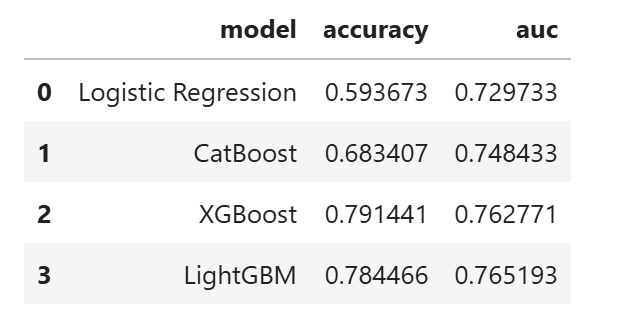

## Model Eval Metrics

In [32]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, average_precision_score
)

# Custom threshold
custom_threshold = 0.45

# Convert probs → predictions
y_pred_04 = (y_probs >= custom_threshold).astype(int)

print("===== MODEL EVALUATION @ THRESHOLD = 0.45 =====\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_04))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_04))

print("Accuracy:", accuracy_score(y_test, y_pred_04))
print("Precision:", precision_score(y_test, y_pred_04))
print("Recall:", recall_score(y_test, y_pred_04))
print("F1 Score:", f1_score(y_test, y_pred_04))

print("\nROC-AUC  :", roc_auc_score(y_test, y_probs))
print("PR-AUC   :", average_precision_score(y_test, y_probs))


===== MODEL EVALUATION @ THRESHOLD = 0.45 =====

Confusion Matrix:
[[19049  3354]
 [  912  1057]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     22403
           1       0.24      0.54      0.33      1969

    accuracy                           0.82     24372
   macro avg       0.60      0.69      0.62     24372
weighted avg       0.90      0.82      0.85     24372

Accuracy: 0.8249630723781388
Precision: 0.23962820222171843
Recall: 0.5368207211782631
F1 Score: 0.3313479623824451

ROC-AUC  : 0.7747320670771914
PR-AUC   : 0.28846307956419354


## Business Interpretation

1. Captures 52% of defaulters, with 84% Accuracy and 25% Precision.


   Higher precision is possible by increasing the threshold, with a trade-off in recall. (conservative Approach)

3. ROC-AUC of 0.77 indicates good ranking quality.


## Saving the Model

In [33]:
import joblib

artifacts = {
    "model": model,                     # final ensemble
    "preprocessor": PREPROCESSOR,       # all preprocessing components
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "selected_features": PREPROCESSOR.get("selected_features"),
    "threshold": BEST_THRESHOLD         # tuned threshold
}

joblib.dump(artifacts, "loan_default_final_model.pkl")

print("\nModel saved successfully as: loan_default_final_model.pkl")



Model saved successfully as: loan_default_final_model.pkl


## Comparing Different Threshold

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def threshold_compare(model, X_test_raw, y_test, thresholds=[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65]):
    """
    Compare metrics across different thresholds using a
    **consistent preprocessing + prediction pipeline**.

    This function recomputes probabilities inside using the same
    logic as `evaluate_on_test`, so results at any threshold
    (e.g. 0.4) will match the manual evaluation with the same model.
    """

    # 1) Preprocess test data (infer mode)
    X_test_prep = full_preprocess_pipeline(
        X_test_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="infer"
    )

    # 2) Apply the same supervised feature selection
    X_test_prep = apply_feature_selection(X_test_prep)

    # 3) Get probabilities from the current model
    y_probs = model.predict_proba(X_test_prep)[:, 1]

    # 4) Ensure alignment
    y_true = pd.Series(y_test).reset_index(drop=True)
    y_probs = pd.Series(y_probs).reset_index(drop=True)

    rows = []

    for th in thresholds:
        y_pred = (y_probs >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        rows.append({
            "Threshold": th,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "TP": tp,
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred),
            "F1": f1_score(y_true, y_pred),
            "Accuracy": accuracy_score(y_true, y_pred),
            "ROC-AUC": roc_auc_score(y_true, y_probs),
            "PR-AUC": average_precision_score(y_true, y_probs)
        })

    return pd.DataFrame(rows)

# Usage after you have a trained `model` and defined X_test_raw, y_test
df_thr = threshold_compare(model, X_test_raw, y_test)
df_thr


,Threshold,TN,FP,FN,TP,Precision,Recall,F1,Accuracy,ROC-AUC,PR-AUC
0,0.20,12200,10203,364,1605,0.135925,0.815135,0.232997,0.566429,0.773201,0.291488
1,0.25,14226,8177,484,1485,0.153695,0.754190,0.255352,0.644633,0.773201,0.291488
2,0.30,15957,6446,613,1356,0.173802,0.688674,0.277556,0.710364,0.773201,0.291488
3,0.35,17248,5155,725,1244,0.194405,0.631793,0.297323,0.758740,0.773201,0.291488
4,0.40,18334,4069,812,1157,0.221393,0.587608,0.321612,0.799729,0.773201,0.291488
5,0.45,19223,3180,936,1033,0.245193,0.524632,0.334196,0.831118,0.773201,0.291488
6,0.50,19965,2438,1053,916,0.273107,0.465211,0.344167,0.856762,0.773201,0.291488
7,0.55,20561,1842,1143,826,0.309595,0.419502,0.356265,0.877523,0.773201,0.291488
8,0.60,21038,1365,1262,707,0.341216,0.359066,0.349913,0.892212,0.773201,0.291488
9,0.65,21447,956,1389,580,0.377604,0.294566,0.330956,0.903783,0.773201,0.291488


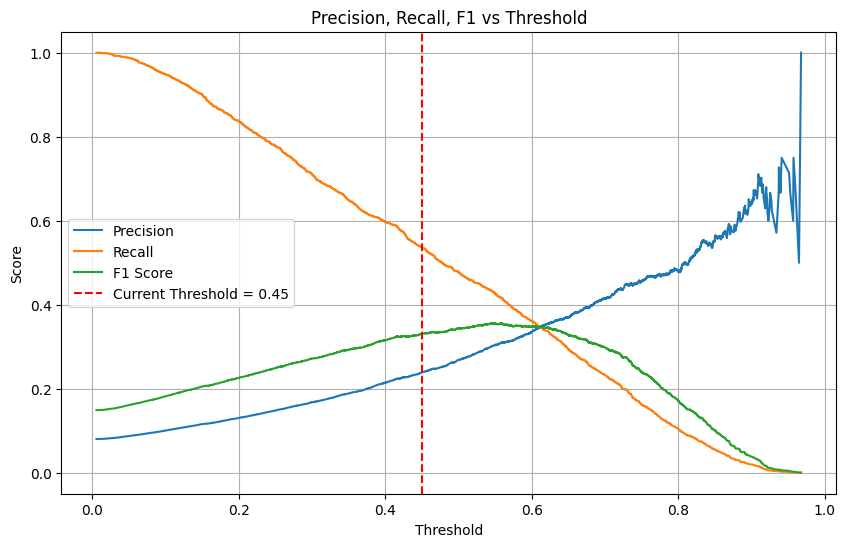

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(0.45, color='red', linestyle='--', label='Current Threshold = 0.45')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.grid()
plt.show()


## Feature Importance

In [24]:
def get_final_feature_names():
    """Return final feature names after preprocessing + feature selection."""
    # After training, PREPROCESSOR holds selected features
    return PREPROCESSOR["selected_features"]


def get_model_feature_importance(model, top_n=30):
    """
    Return sorted feature importances for tree-based models.
    Works for ExtraTrees, XGB, LGBM, CatBoost.
    """
    feature_names = get_final_feature_names()

    # XGB, LGBM, ExtraTrees all have either feature_importances_ or coef_ (LR)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

    elif hasattr(model, "coef_"):  # For Logistic Regression
        importances = np.abs(model.coef_[0])

    else:
        raise ValueError("Model does not provide feature importances")

    df_imp = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    return df_imp.head(top_n)

def get_ensemble_feature_importance(voting_model):
    """
    Weighted average of feature importances of individual models.
    Works only if all models have feature_importances_.
    """
    feature_names = get_final_feature_names()
    total_importance = np.zeros(len(feature_names))

    for (name, model), weight in zip(voting_model.estimators, voting_model.weights):
        if hasattr(model, "feature_importances_"):
            total_importance += model.feature_importances_ * weight
        elif hasattr(model, "coef_"):
            total_importance += np.abs(model.coef_[0]) * weight  # LR

    df = pd.DataFrame({"feature": feature_names, "importance": total_importance})
    return df.sort_values("importance", ascending=False)

def get_ensemble_feature_importance(voting_model):
    """
    Weighted average of feature importances of individual models.
    Works only if all models have feature_importances_.
    """
    feature_names = get_final_feature_names()
    total_importance = np.zeros(len(feature_names))

    for (name, model), weight in zip(voting_model.estimators, voting_model.weights):
        if hasattr(model, "feature_importances_"):
            total_importance += model.feature_importances_ * weight
        elif hasattr(model, "coef_"):
            total_importance += np.abs(model.coef_[0]) * weight  # LR

    df = pd.DataFrame({"feature": feature_names, "importance": total_importance})
    return df.sort_values("importance", ascending=False)

df_ens = get_ensemble_feature_importance(model)
df_ens.head(15)


,feature,importance
20,NEW_Payment_Rate,5403.338684
5,Age_Days,5045.663581
7,Registration_Days,4699.068891
6,Employed_Days,4503.379240
19,NEW_Score_Var,4466.423694
21,NEW_Income_per_Age,4374.009806
14,Phone_Change,4283.683194
22,NEW_Region_Adjusted_Income,4109.726981
18,NEW_Score_Min,4057.538957
17,NEW_Score_Max,3985.173254


## Checking Overfitting

In [23]:
def overfitting_report(model, X_train_raw, y_train, X_test_raw, y_test, threshold=0.4):
    """
    Check for overfitting by comparing train vs test performance using 
    the same preprocessing + feature selection + prediction pipeline.
    """

    # ==== TRAIN PREDICTIONS ====
    X_train_prep = full_preprocess_pipeline(
        X_train_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="infer"
    )

    X_train_prep = apply_feature_selection(X_train_prep)

    y_probs_train = model.predict_proba(X_train_prep)[:, 1]

    y_train_true = pd.Series(y_train).reset_index(drop=True)
    y_probs_train = pd.Series(y_probs_train).reset_index(drop=True)
    y_train_pred = (y_probs_train >= threshold).astype(int)

    # ==== TEST PREDICTIONS ====
    X_test_prep = full_preprocess_pipeline(
        X_test_raw,
        numerical_cols=numeric_cols,
        categorical_cols=categorical_cols,
        mode="infer"
    )

    X_test_prep = apply_feature_selection(X_test_prep)

    y_probs_test = model.predict_proba(X_test_prep)[:, 1]

    y_test_true = pd.Series(y_test).reset_index(drop=True)
    y_probs_test = pd.Series(y_probs_test).reset_index(drop=True)
    y_test_pred = (y_probs_test >= threshold).astype(int)

    # ==== METRICS ====
    train_auc = roc_auc_score(y_train_true, y_probs_train)
    test_auc = roc_auc_score(y_test_true, y_probs_test)

    train_pr = average_precision_score(y_train_true, y_probs_train)
    test_pr = average_precision_score(y_test_true, y_probs_test)

    train_f1 = f1_score(y_train_true, y_train_pred)
    test_f1 = f1_score(y_test_true, y_test_pred)

    print("\n================== OVERFITTING REPORT ==================\n")
    print(f"Threshold used: {threshold}")
    print(f"Train AUC     : {train_auc:.4f}")
    print(f"Test AUC      : {test_auc:.4f}")
    print(f"Train PR-AUC  : {train_pr:.4f}")
    print(f"Test PR-AUC   : {test_pr:.4f}")
    print(f"Train F1      : {train_f1:.4f}")
    print(f"Test F1       : {test_f1:.4f}")

    # ==== VERDICT ====
    print("\n------------------ VERDICT ------------------")

    auc_gap = train_auc - test_auc
    pr_gap = train_pr - test_pr

    if auc_gap < 0.03 and pr_gap < 0.03:
        print("✔ Model is well-generalized (No overfitting).")
    elif auc_gap < 0.07:
        print("⚠ Slight overfitting but acceptable.")
    else:
        print("❌ Model is overfitting. Reduce complexity or add regularization.")

    print("--------------------------------------------------------\n")

overfitting_report(model, X_train_raw, y_train, X_test_raw, y_test, threshold=0.5)



================== OVERFITTING REPORT ==================

Threshold used: 0.5
Train AUC     : 0.9902
Test AUC      : 0.7747
Train PR-AUC  : 0.8891
Test PR-AUC   : 0.2885
Train F1      : 0.6854
Test F1       : 0.3437

------------------ VERDICT ------------------
❌ Model is overfitting. Reduce complexity or add regularization.
--------------------------------------------------------



## Prediction

In [34]:

# ============================================================
# 6. DEPLOYMENT: LOAD + PREDICTION ON NEW DATA
# ============================================================

def load_system(artifact_path="loan_default_system.pkl"):
    artifacts = joblib.load(artifact_path)

    model = artifacts["model"]
    preprocessor = artifacts["preprocessor"]
    num_cols = artifacts["numeric_cols"]
    cat_cols = artifacts["categorical_cols"]
    threshold = artifacts["threshold"]

    return model, preprocessor, num_cols, cat_cols, threshold


def predict_on_new_df(df_new, model, preprocessor, num_cols, cat_cols, threshold):
    """
    df_new: raw dataframe with same structure as training data (except target).
    Returns df with prediction & probability columns added.
    """
    global PREPROCESSOR
    PREPROCESSOR = preprocessor  # load state into global used by pipeline

    X_prep = full_preprocess_pipeline(
        df_new,
        numerical_cols=num_cols,
        categorical_cols=cat_cols,
        mode="infer"
    )

    probs = model.predict_proba(X_prep)[:, 1]
    preds = (probs >= threshold).astype(int)

    out = df_new.copy()
    out["prob_default"] = probs
    out["pred_default"] = preds

    return out

In [35]:


df_sample = original_df
y_sample_true = df_sample['Default']     # target column
X_sample = df_sample.drop(columns=['Default','ID'])


In [36]:
# ===============================
# 2) DEPLOYMENT / SCORING
# ===============================
from pycaret.classification import load_model

# Load system
model, preprocessor, num_cols, cat_cols, threshold = load_system("loan_default_final_model.pkl")

# Load new data (must NOT contain 'Default' column)
new_data = X_sample

# Score new applications
scored = predict_on_new_df(
    df_new=new_data,
    model=model,
    preprocessor=preprocessor,
    num_cols=num_cols,
    cat_cols=cat_cols,
    threshold=threshold
)


Confusion Matrix:
 [[99710 12301]
 [  966  8879]]

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    112011
           1       0.42      0.90      0.57      9845

    accuracy                           0.89    121856
   macro avg       0.70      0.90      0.75    121856
weighted avg       0.94      0.89      0.91    121856

Accuracy: 0.8911255908613446


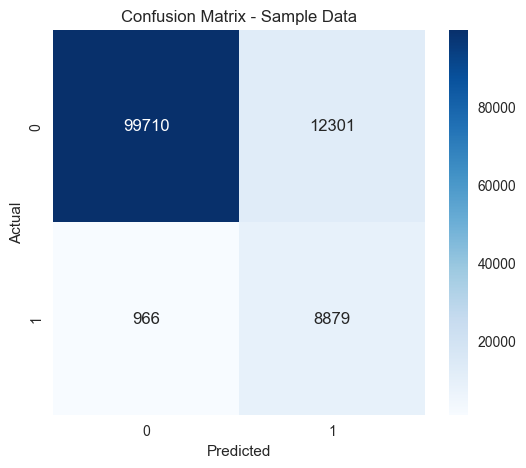

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = scored["pred_default"]

# Convert to numpy arrays for safety
y_true = y_sample_true.values
y_pred = y_pred.values

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# --- Accuracy ---
print("Accuracy:", accuracy_score(y_true, y_pred))

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sample Data")
plt.show()
